# Tarea 6: Segmentacion semantica.
  `Diego Irarrazaval`
  
  `10 de Enero`

El objetivo de esta tarea es entrenar e implementar una CNN cuya tarea a resolver es el problema de la segmentacion semantica. 

En el informe, se mustran los resultados de lo siguiente:
- Implementacion de KittiDataset.
- Adaptacion del codigo de entrenamiento
- Entrenamiento
- Graficos de distintos resultados y sus analisis


## Carga de librerias e importacion de `Pytorch-UNet`
Carga de algunas librerias: en particular, se destaca la clonacion del repositorio [Pytorch-UNet](https://github.com/milesial/Pytorch-UNet).

In [3]:
import cv2
import os.path 
from PIL import Image

try:
  import google.colab as colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Cargamos los datos solo la primera vez que nos conectamos a la "runtime":
# La descarga se hace automatica desde un repo en github
if IN_COLAB:
  from google.colab.patches import cv2_imshow
  !pip install -U opencv-python

Requirement already up-to-date: opencv-python in /usr/local/lib/python3.6/dist-packages (4.5.1.48)


In [4]:
import argparse
import logging
import os
import sys

import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from torch.utils.data import Dataset
from PIL import Image
from os.path import splitext
from os import listdir
import glob
!pip install torchsummary
from torchsummary import summary
from torch.utils.data import DataLoader, random_split

In [5]:
if not os.path.exists('pytorch_unet'):
  # A continuacion se clona el repo
  !git clone https://github.com/milesial/Pytorch-UNet.git
  # Se instalan los requisitos del repo
  !pip install -r Pytorch-UNet/requirements.txt
  # se renombra para poder importar las funciones
  !mv Pytorch-UNet pytorch_unet
  !cp pytorch_unet/dice_loss.py ../content/
  !cp pytorch_unet/eval.py ../content/

Carga del dataset:

In [6]:
if not os.path.exists('data_semantics.zip'):
  !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
  !unzip data_semantics.zip

In [8]:
# Importamos las funciones del repositorio
from pytorch_unet.unet import UNet
# from kitti_inverse_map_1channel import kitti_inverse_map_1channel

## Transformaciones e implementacion del `KittiDataset`:
La implementacion de las transformaciones se realizo en la misma clase `KittiDataset`. De esta forma, a medida que se entregaba cada imagen se aplicaba el preprocesamiento.

Visualicemos una de las imagenes:

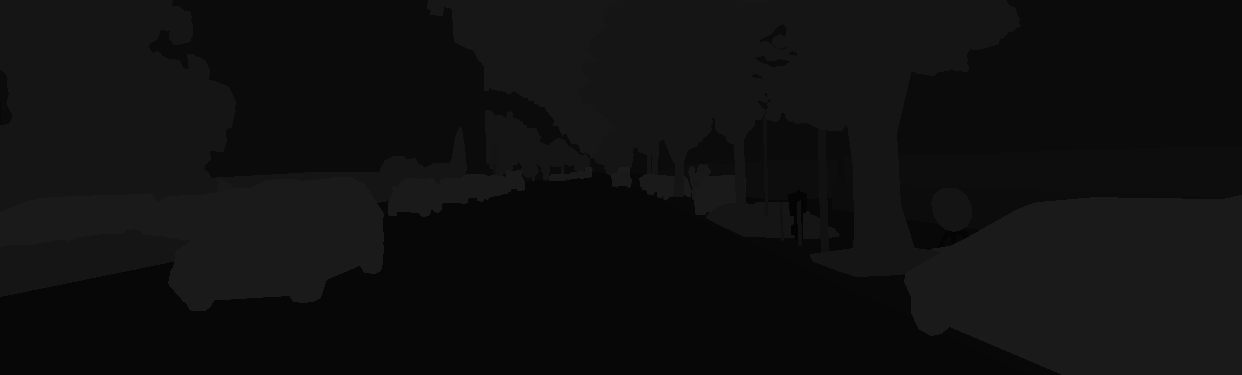

In [233]:
test_im = cv2.imread('/content/training/semantic/000000_10.png')
cv2_imshow(test_im)

In [10]:
# Esta funcion debe ser copiada a una celda de colaboratory para poder usarla

from numba import jit
@jit(nopython=True)
def kitti_inverse_map_1channel(img):
  cmap = [
    (0, 0), #void (ignorable) 
    (4, 0),
    (5, 0),
    (6, 0),
    (7, 1), #road
    (8, 2), #sidewalk
    (9, 2),
    (10, 0), #rail truck (ignorable)
    (11, 3), #construction
    (12, 3),
    (13, 3),
    (14, 3),
    (15, 3),
    (16, 3),
    (17, 4), #pole(s)
    (18, 4),
    (19, 5), #traffic sign
    (20, 5),
    (21, 6), #vegetation
    (22, 6),
    (23, 7),
    (24, 8), #sky
    (25, 8),
    (26, 9), #human
    (27, 9),
    (28, 9),
    (29, 9),
    (30, 9),
    (31, 10), #train
    (32, 11), #cycle
    (33, 11)
  ]  

  arrmap = np.zeros( (34), dtype=np.int32 )

  for el in cmap:
    arrmap[el[0]] = el[1]

  val = np.ones((img.shape[0],img.shape[1]), dtype=np.int32) * -1

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      val[i,j] = arrmap[img[i,j]]
  return val

Implementacion `KittiDataset`: Basado en la implementacion `BasicDataset` del repositorio que se indica mas arriba. 

In [281]:
from os.path import splitext
from os import listdir
import numpy as np
import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image


class KittiDataset(Dataset):
  def __init__(self, imgs_dir, masks_dir, read_mask, scale=1, mask_suffix=''):
    super(KittiDataset, self).__init__()
  # def __init__(self, imgs_dir, masks_dir, scale=1, mask_suffix=''):
    self.imgs_dir = imgs_dir
    self.masks_dir = masks_dir
    self.read_mask = read_mask
    self.scale = scale
    self.mask_suffix = mask_suffix
    assert 0 < scale <= 1, 'Scale must be between 0 and 1'

    self.ids = [splitext(file)[0] for file in listdir(imgs_dir)
                if not file.startswith('.')]
    logging.info(f'Creating dataset with {len(self.ids)} examples')

  def __len__(self):
    return len(self.ids)

  @classmethod
  def preprocess(cls, pil_img, scale):
    w, h = pil_img.size
    newW, newH = int(scale * w), int(scale * h)
    assert newW > 0 and newH > 0, 'Scale is too small'
    pil_img = pil_img.resize((newW, newH))

    img_nd = np.array(pil_img)

    if len(img_nd.shape) == 2:
      img_nd = np.expand_dims(img_nd, axis=2)

    # HWC to CHW
    img_trans = img_nd.transpose((2, 0, 1))
    if img_trans.max() > 1:
      img_trans = img_trans / 255

    return img_trans

  def __getitem__(self, i):
    idx = self.ids[i]
    mask_file = glob.glob(self.masks_dir + idx + self.mask_suffix + '.*')
    img_file = glob.glob(self.imgs_dir + idx + '.*')
    if self.read_mask:
      mask_file = glob.glob(self.masks_dir + idx + self.mask_suffix + '.*')
      assert len(mask_file) == 1, \
        f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
      assert len(img_file) == 1, \
        f'Either no image or multiple images found for the ID {idx}: {img_file}'
      
      mask = Image.open(mask_file[0])
      img = Image.open(img_file[0])

      assert img.size == mask.size, \
        f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'

      mask = kitti_inverse_map_1channel(np.array(mask, dtype=np.int32))
      img = self.preprocess(img, self.scale)
      return {
      'image': torch.from_numpy(img).type(torch.FloatTensor),
      'mask': torch.from_numpy(mask).type(torch.FloatTensor)
    }
    else:
      mask = np.array([])
    
    img = Image.open(img_file[0])
    img = self.preprocess(img, self.scale)
    return {
      'image': torch.from_numpy(img).type(torch.FloatTensor),
      'mask': mask
    }


## Modificacion `train_net`:

In [234]:
import argparse
import logging
import os
import sys
import glob

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from pytorch_unet import dice_loss as dice_loss

from eval import eval_net
from pytorch_unet.unet import UNet

from torch.utils.tensorboard import SummaryWriter
# from utils.dataset import BasicDataset
from torch.utils.data import DataLoader, random_split

dir_img = 'training/image_2/'
dir_mask = 'training/semantic/'
dir_checkpoint = 'checkpoints/'

def train_net(net,
              device,
              epochs=7,
              batch_size=1,
              lr=0.001,
              val_percent=0.1,
              save_cp=True,
              img_scale=0.5):

  dataset = KittiDataset(dir_img, dir_mask, True,img_scale)
  n_val = int(len(dataset) * val_percent)
  n_train = len(dataset) - n_val
  train, val = random_split(dataset, [n_train, n_val])
  train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
  val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)

  writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
  global_step = 0

  logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {lr}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_cp}
        Device:          {device}
        Images scaling:  {img_scale}''')

  optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)
  if net.n_classes > 1:
    criterion = nn.CrossEntropyLoss()
  else:
    criterion = nn.BCEWithLogitsLoss()

  train_loss, val_loss = [], []
  for epoch in range(epochs):
    net.train()

    epoch_loss = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
      for batch in train_loader:
        imgs = batch['image']
        true_masks = batch['mask']
        assert imgs.shape[1] == net.n_channels, \
            f'Network has been defined with {net.n_channels} input channels, ' \
            f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
            'the images are loaded correctly.'

        imgs = imgs.to(device=device, dtype=torch.float32)
        mask_type = torch.float32 if net.n_classes == 1 else torch.long
        true_masks = true_masks.to(device=device, dtype=mask_type)

        masks_pred = net(imgs)
        loss = criterion(masks_pred, true_masks)
        epoch_loss += loss.item()
        writer.add_scalar('Loss/train', loss.item(), global_step)

        pbar.set_postfix(**{'loss (batch)': loss.item()})

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(net.parameters(), 0.1)
        optimizer.step()

        pbar.update(imgs.shape[0])
        global_step += 1
        if global_step % (n_train // (10 * batch_size)) == 0:
          for tag, value in net.named_parameters():
            tag = tag.replace('.', '/')
            writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
            writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), global_step)
          val_score = eval_net(net, val_loader, device)
          scheduler.step(val_score)
          writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], global_step)

          if save_cp:
            torch.save(net.state_dict(),
            dir_checkpoint + f'CP_middle_epoch{epoch + 1}.pth')

          if net.n_classes > 1:
            logging.info('Validation cross entropy: {}'.format(val_score))
            writer.add_scalar('Loss/test', val_score, global_step)
          else:
            logging.info('Validation Dice Coeff: {}'.format(val_score))
            writer.add_scalar('Dice/test', val_score, global_step)

          writer.add_images('images', imgs, global_step)
          if net.n_classes == 1:
            writer.add_images('masks/true', true_masks, global_step)
            writer.add_images('masks/pred', torch.sigmoid(masks_pred) > 0.5, global_step)
    train_loss.append(loss.item())
    val_loss.append(val_score)
    if save_cp:
      # if not os.path.exists(dir_checkpoint):
      # os.mkdir(dir_checkpoint)
      logging.info('Created checkpoint directory')
      torch.save(net.state_dict(),
                  dir_checkpoint + f'CP_epoch{epoch + 1}.pth')
      print(f'Checkpoint {epoch + 1} guardado')
      logging.info(f'Checkpoint {epoch + 1} saved !')

  writer.close()
  return train_loss, val_loss

In [ ]:
net = UNet(n_channels=3, n_classes=12, bilinear=True)
device = 'cuda'
net.to(device)
try:
  train_loss, val_loss = train_net(net=net,
                                  epochs=7,
                                  batch_size=1,
                                  lr=.001,
                                  device=device,
                                  img_scale=1,
                                  val_percent=.1)
  
except KeyboardInterrupt:
  torch.save(net.state_dict(), 'INTERRUPTED.pth')
  logging.info('Saved interrupt')
  try:
    sys.exit(0)
  except SystemExit:
    os._exit(0)

(Para el informe, se elimino el output de la celda anterior que es muy verboso y poco util para el analisis).
Veamos la funcion de perdida a lo largo del entrenamiento:

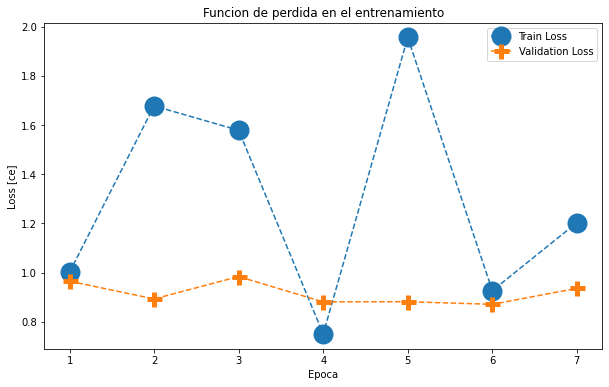

In [239]:
plt.figure(figsize=(10,6))
plt.plot(range(1, 8), train_loss, '--o', label='Train Loss', mew=5, ms=15)
plt.plot(range(1, 8), val_loss, '--+', label='Validation Loss', mew=5, ms=15)
plt.title('Funcion de perdida en el entrenamiento')
plt.xlabel('Epoca')
plt.ylabel('Loss [ce]')
plt.legend()
plt.show()

## Predicciones:
En esta seccion, primero se crean algunas funciones auxiliares que seran de ayuda en las predicciones:
- `predict_img` se basa en una funcion del repositorio. Esta recibe una red, una imagen, el parametro `with_mask` y el _device_ y entrega la imagen original RGB, la mascara predica y si el parametro `with_mask == True`, entrega la mascara original. 
- `predict_lote` recibe una red, un _dataloader_,  cantidad (`int`) y  `with_mask` (con default `False`) y predice para la cantidad indicada segun las imagenes del _dataloader_ utilizando la red y la funcion descrita justo antes. Entrega una lista con las imagenes utilizadas, la lista de las mascaras predichas y si `with_mask == True`, entrega la lista de las mascaras.
- `plot_img_and_mask` permite graficar listas de imagenes. Recibe la lista de imagenes originales RGB, las mascaras predichas y como opcional, las mascaras reales y grafica todas las imagenes de la lista. 


In [237]:
def predict_img(net,
                data,
                with_mask = False,
                device='cuda'):
    net.to(device)
    net.eval()

    # img = torch.from_numpy(BasicDataset.preprocess(full_img, scale_factor))

    # img = img.unsqueeze(0)
    # img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
      img = data['image']
      # temp_img = data['image']
      # img = temp_img.numpy().transpose(2,3,1,0)
      # img = torch.from_numpy(np.squeeze(img))

      output = net(img.to(device)).cpu().detach().numpy()
      # out_mask = output.squeeze().cpu().numpy().transpose(2,3,1,0)
      out_mask = np.argmax(output.transpose(2,3,1,0), axis=2)
      
      if with_mask:
        mask = np.squeeze(data['mask'].numpy().transpose(1,2,0))
        return img, out_mask, mask
      return img, out_mask


In [264]:
def plot_img_and_mask(img, predicted_mask, mask=None):
  l_imgs = len(img)
  l_masks = len(predicted_mask)
  if mask is None:
    fig, axs = plt.subplots(l_imgs,2,figsize=(11, 11))
  else:
    fig, axs = plt.subplots(l_imgs,3,figsize=(13, 13))

  for i, im in enumerate(img):
    axs[i, 0].imshow(np.squeeze(im.numpy().transpose(2,3,1,0)))
    axs[i, 0].set_title('True Image RGB')
    axs[i, 1].imshow(np.squeeze(predicted_mask[i]))
    axs[i, 1].set_title('Mascara predicha')
    if mask is not None:
      axs[i, 2].imshow(mask[i])
      axs[i, 2].set_title('Mascara real')

  plt.xticks([]), plt.yticks([])
  plt.show()


In [286]:
def predecir_lote(net, data_loader, cantidad, with_mask = False):
  if with_mask:
    imgs, results, masks =[], [], []
  else:
    imgs, results = [], []
  for i, data in enumerate(data_loader):
    if with_mask:
      img, pred_mask, mask = predict_img(net, data, with_mask)
      results.append(pred_mask)
      masks.append(mask)
      imgs.append(img)
    else:
      img, pred_mask = predict_img(net, data, with_mask)
      results.append(pred_mask)
      imgs.append(img)
    if i == cantidad-1:
      break
  return imgs, results, masks if with_mask else imgs, results

In [241]:
# cargamos la red que se obtiene en la 2 y en la ultima epoca:

net_2 = UNet(n_channels=3, n_classes=12)
second_checkpoint = torch.load(dir_checkpoint + 'CP_epoch2.pth')
net_2.cuda()
net_2.eval()
net_2.load_state_dict(second_checkpoint)

net_7 = UNet(n_channels=3, n_classes=12)
seventh_checkpoint = torch.load(dir_checkpoint + 'CP_epoch7.pth')
net_7.cuda()
net_7.eval()
net_7.load_state_dict(seventh_checkpoint)

<All keys matched successfully>

### Pruebas sobre train set:
A continuacion, se muestra las pruebas de las dos redes (con chekckpoint hasta la segunda epoca y hasta la 7ma) en 5 imagenes del set de entrenamiento. Se observa la imagen RGB, la mascara predicha y la real.

**Se aplica con `Shuffle=True` para que salgan las mismas imagenes para ambas redes y asi las comparaciones tengan mas sentido.**

In [292]:
# Train loader para imagenes de prueba en la red:
dataset = KittiDataset(dir_img, dir_mask, True, 1)
train_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

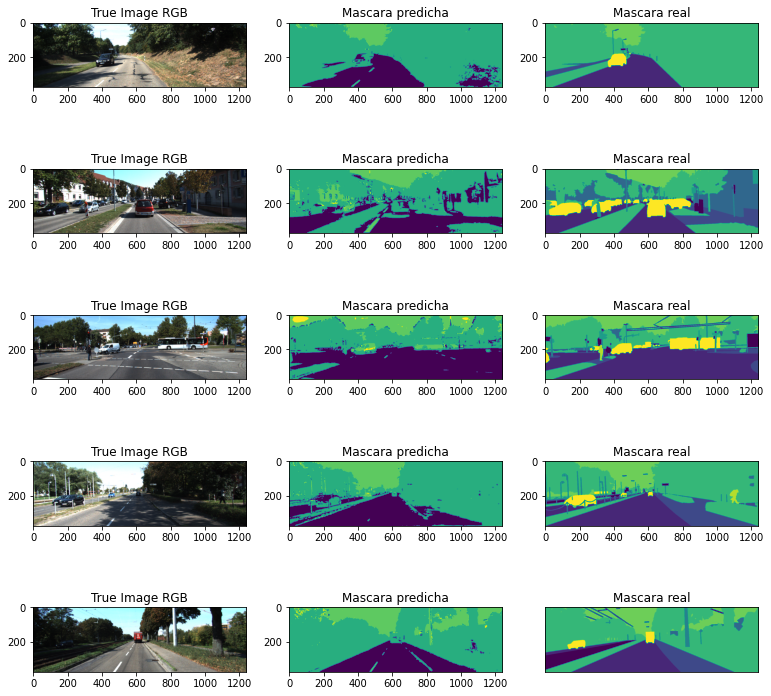

In [293]:
with_mask = True
results = predecir_lote(net_2, train_loader, 5, with_mask)
plot_img_and_mask(results[0], results[1], results[2])

**COMENTARIOS:**  Se observa en primer lugar que en la red tomando hasta el segundo checkpoint, tiene menor capacidad para segmentar e incluso hay varias clases que no reconoce. Los autos, buses y otros los confunde con calle o con vereda y secciones laterales de locales o casas. 
Se observa de todas formas en la tecera imagen que hay cierta segmentacion algo similar a la mascara real. 

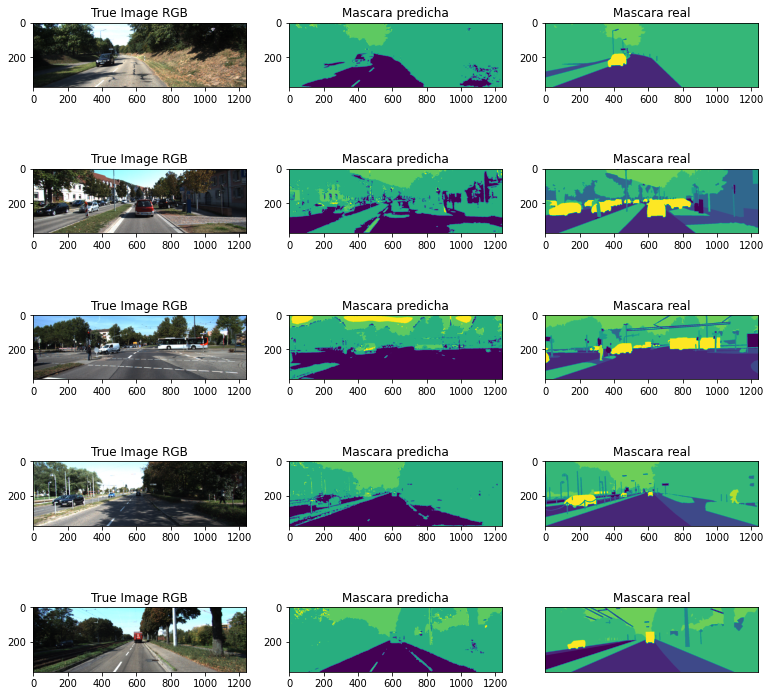

In [294]:
dataset = KittiDataset(dir_img, dir_mask, True, 1)
train_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
results = predecir_lote(net_7, train_loader, 5, with_mask)
plot_img_and_mask(results[0], results[1], results[2])

**COMENTARIOS:** Se observan leves diferencias en la capacidad de segmentacion luego de 5 epocas. En particular en la tercera imagen, se observan algunos segmentos que anteriormente no habia en el cielo. 

En ambos casos (con 2 epocas o con 7), la quinta imagen tiene mal desempeno y no puede segmentar los autos, postes o arboles. 

**Sobre este experimento:** Se infiere que si se entrenara por mas epocas, tal vez podria mejorar la calidad del segmentador. Esto tambien depende de otros factores como la arquitectura, etc...

### Pruebas sobre test set:
En las siguientes celdas se muestran las pruebas sobre el conjunto de test:

In [289]:
test_dir = 'testing/image_2/'

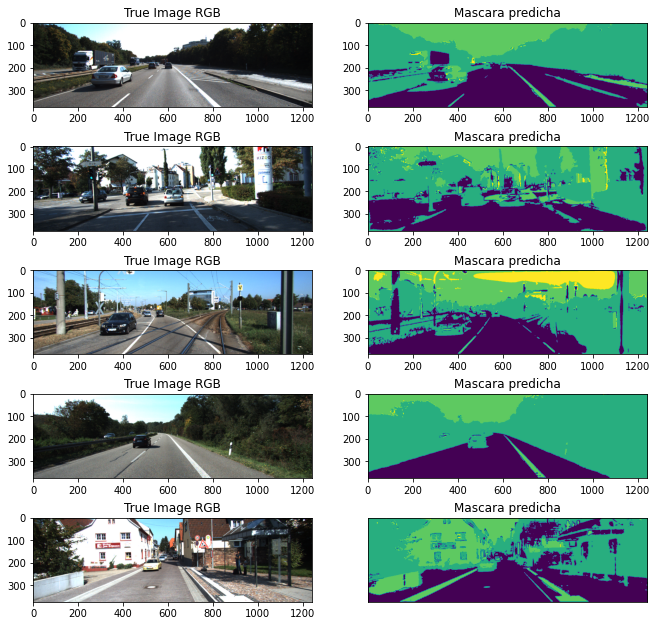

In [290]:
data_test = KittiDataset(imgs_dir=test_dir, masks_dir=mask_dir, read_mask=False)
test_loader = DataLoader(data_test, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)
results = predecir_lote(net_2, test_loader, 5)
plot_img_and_mask(results[0], results[1])

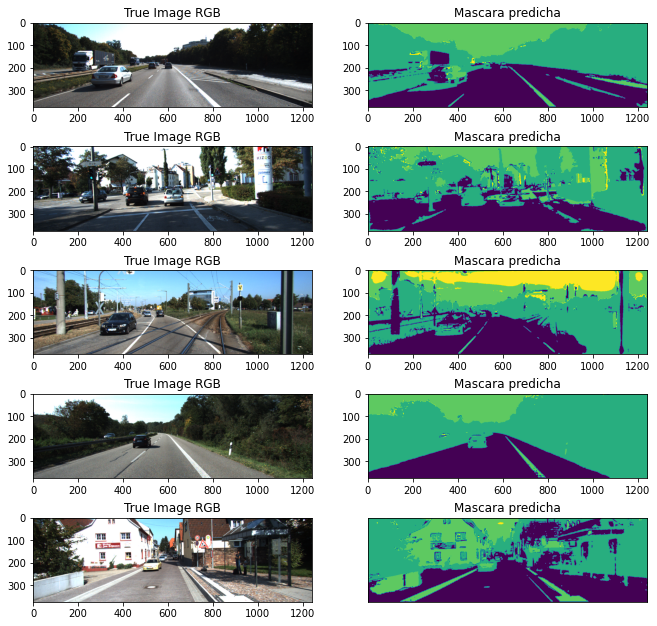

In [291]:
data_test = KittiDataset(imgs_dir=test_dir, masks_dir=mask_dir, read_mask=False)
test_loader = DataLoader(data_test, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)
results = predecir_lote(net_7, test_loader, 5)
plot_img_and_mask(results[0], results[1])

**COMENTARIOS:** Al igual que las pruebas con el conjunto de entrenamiento, no se observan mayores diferencias en las segmentaciones entre las dos redes. Las principales diferencias se observan en el cielo (en la quinta imagen, la red con 7 epocas identifico una pequena mancha amarilla) y en algunos pequenos detalles. 

Es dificil concluir si esto es debido a un error en la implementacion o a la cantidad de epocas utilizadas en el entrenamiento y, debido al tiempo que toma entrenar la red, no se realizaron experimentos con mas epocas. 

## Conclusiones:

- En primer lugar, se aprendio a utilizar un repositorio no propio en google colab. En particular este que implementaba una red para segmentacion semantica. 
- Se comprendio la gran dificultad para cargar los datos y, mas importante, dada la estructura del dataset, se observa que la construccion de este debe ser una tarea muy dificil y cara. Uno de los puntos mas dificiles de resolver en cualquier problema de _Deep Learning_ es la construccion del dataset, en caso que este no exista. 
- Se observo una leve mejora en el resultado obtenido al entrenar 5 epocas mas (en realidad se cargaron los _checkpoints_, pero para efectos de resultados, es equivalente). Aunque hay leves mejoras, se ifiere que si se entrenara por mas epocas se podria obtener mejores resultados. Tal vez, aumentando el tamano del dataset se pueda mejorar tambien el desempeno. La arquitectura de la red es otro elemento que afecta en el desempeno. Hay algunas redes que con pocas imagenes de entrenamiento (_few shot_) obtienen muy buenos resultados. 
